In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
import astropy.units as u
import sys 
import os
sys.path.append("../src")
from regression import FrequentistRegression
# from scipy.optimize import curve_fit
params = {
         'axes.labelsize': 25,
         'axes.titlesize': 25,
         'ytick.labelsize' :25,
         'xtick.labelsize' :25,
         'legend.fontsize': 20,
         'xtick.major.size': 5,
         'xtick.minor.size': 4,
         'xtick.major.width': 3,
         'xtick.minor.width': 2,
         'ytick.major.size': 5,
         'ytick.minor.size': 4,
         'ytick.major.width': 3,
         'ytick.minor.width': 2,
         'ytick.color': "k",
         'xtick.color': "k",
         'axes.labelcolor': "k",
         'ytick.labelcolor' : "k",
         'xtick.labelcolor' : "k",
         'font.size': 20
         }
plt.rcParams.update(params)
plt.style.use('science')

figure_folder = 'C://Users//noedi//Desktop//lab_optique//data//optique_non_lineaire'

## Semaine 1: 

***Avant de commencer, voici la [musique de la semaine](https://www.youtube.com/watch?v=VePaI3jX4Sk)***.

Les différentes expériences de cette semaine incluent: 
1) Mesures de la loi de Malus
2) Mesures du spectre $I$ vs $\lambda$ du laser autour de 1064 nm (avec un courant dans la pompe $I_p$ constant)
3) Mesures du rapport $\frac{I_{max}(1064 \text{nm})}{I_{max}(\text{808 nm})}$ en fonction du courant dans la pompe. 


#### Loi de Malus. 

La loi de Malus relie l'intensité d'une onde polarisée linéairement d'intensité $I_0 = \sqrt{E_0}$ à l'intensité $I$ de l'onde après son passage dans un polariseur linéaire parfait orienté selon un angle $\theta - \phi$ par rapport au plan de propagation de l'onde. Mathématiquement, on a 
$$
I(\theta) = I_0 \cos^2(\theta - \phi) \, .
$$
Durant l'expérience, on mesurait seulement $\theta$, l'angle de polarisation du polariseur par rapport à la verticale. Cependant, la loi de Malus s'applique pour **l'angle de polarisation entre le polariseur et la direction de polarisation du laser** et on doit introduire le déphasage $\phi$. Il nous faut donc ajuster deux paramètres, $I_0$ et $\phi$. 

Parlons d'incertitudes avant de commencer le code. On utilise la plus demie-mesure de la plus petite graduation de notre instrument de mesure pour l'angle, donc $\sigma_\theta \sim 2$ degrés. Pour I, on prend une vingtaine de mesures au même angle en réinitialisant le set up expérimental à chaque fois et on mesure l'écart type de cet ensemble de mesures. 

Petit calcul pour "rendre la loi de Malus linéaire": 
$$
\begin{align}
\cos^2(\theta - \phi)&=\frac{1 + \cos\left(2(\theta - \phi)\right)}{2}
\\
&=\frac{1}{2} + \frac{1}{2}\cos(2(\theta - \phi))
\\
&=\frac{1}{2} + \frac{1}{2}\left[\cos(2\theta)\cos(2\phi) + \sin(2 \theta)\sin(2 \phi) \right]
\\
&= \frac{1}{2} + \beta_1\cos(2\theta) +\beta_2 \sin(2 \theta) 
\end{align}
$$
On peut donc réécrire la loi de Malus de manière linéaire comme 
$$
I(\theta) = \beta_0 + \beta_1 \cos(2 \theta) + \beta_2 \sin(2\theta)
$$
où les $\beta_i$ sont les paramètres à ajuster avec 
$$
\begin{align}
\beta_0 = \frac{I_0}{2} &\rightarrow I_0 = 2 \beta_0
\\
\beta_1 = \frac{I_0}{2} \cos(2\phi) &\rightarrow \phi = \frac{1}{2}\arccos(\beta_1/\beta_0)
\\
\beta_2 = \frac{I_0}{2}\sin(2\phi) &\rightarrow \phi = -\frac{1}{2}\arcsin(\beta_2/\beta_0)
\\
\frac{\beta_2}{\beta_1}= \tan(2 \phi) &\rightarrow \phi = \frac{1}{2}\arctan(\beta_2/\beta_1)
\end{align}
$$

À l'issue de la régression linéaire, on a des incertitudes sur les paramètres ajustées $\beta_i$. On utilise donc la formule de propagation des incertitudes pour retrouver les incertitudes sur les variables physiques $I_0$ et $\phi$.
$$
\begin{align}
I_0 &= 2 \beta_0 \\
\sigma_{I_0} &=|\frac{\partial I_0}{\partial \beta_0}\sigma_{\beta_0}|=2 \sigma_{\beta_0}\\
\phi &= \frac{1}{2} \arctan\left( \frac{\beta_2}{\beta_1}\right)
\\
\frac{\partial \phi}{\partial \beta_2} &= \frac{\beta_1}{2(\beta_1^2 + \beta_2^2)} 
\\
\frac{\partial \phi}{\partial \beta_1} &= -\frac{\beta_2}{2(\beta_1^2 + \beta_2^2)} 
\\
\sigma_\phi &= \sqrt{\left( \frac{\partial \phi}{\partial \beta_1}\right)^2\sigma_{\beta_1}^2 + \left( \frac{\partial \phi}{\partial \beta_2}\right)^2\sigma_{\beta_2}^2} 
\\
&= \sqrt{\left(\frac{\beta_1}{2(\beta_1^2 + \beta_2^2)} \right)^2 \sigma_{\beta_1}^2 + \left(\frac{\beta_2}{2(\beta_1^2 + \beta_2^2)} \right)^2 \sigma_{\beta_2}^2}
\\
&= \frac{1}{2(\beta_1^2 + \beta_2^2)}\sqrt{\beta_1^2\sigma_{\beta_1}^2 + \beta_2 \sigma_{\beta_2}^2}
\end{align}
$$

Dernière équation ici. On va également avoir une incertitude sur l'intensité prédite par la loi de Malus en propageant les incertitudes une dernière fois. 
$$
\begin{align}
\sigma_{I} &= \sqrt{\left( \frac{\partial I}{\partial I_0}\right)^2\sigma_{I_0}^2 + 
\left( \frac{\partial I}{\partial \theta}\right)^2\sigma_{\theta}^2
+
\left( \frac{\partial I}{\partial \phi}\right)^2\sigma_{\phi}^2}
\\
&= \sqrt{\cos^2(\theta-\phi)\sigma_{I_0}^2  + 4 I_0^2\sin^2(\theta-\phi)\cos^2(\theta-\phi)\sigma_{\phi}^2+4 I_0^2\sin^2(\theta-\phi)\cos^2(\theta-\phi)\sigma_{\theta}^2}
\end{align}
$$

Note: De manière équivalente, on peut faire passer les valeurs $(I_{0}, \theta, \phi)$ perturbées par les déviations standards $(\sigma_{I_{0}},\sigma_{\theta}, \sigma_{\phi})$ puis les faire passer dans la loi de Malus afin de propager les incertitudes. Cette méthode implique moins de maths (mais la précédente constitue une belle dérivation!).

In [2]:
# Defining useful functions
def malus_law(theta, I0, phi):
    return I0 * np.cos(theta - phi) ** 2

def fit_params_to_phys_params(param1, param2, param3): 
    """
    Regression parameters to physical parameters
    """
    return np.array([2 * param1, 0.5 * np.arctan(param3 / param2)])

def std_params_to_std_physical(params, stds): 
    """
    Std of regression paramters to std of physical parameters
    """
    sigma_intensity_fitted = 2 * stds[0]

    beta1, beta2 = params[1:]
    sigma_beta1 = stds[1]
    sigma_beta2 = stds[2]
    sigma_phi_fitted = 1 / (beta1 ** 2 + beta2 ** 2) * np.sqrt(beta1 ** 2 * sigma_beta1 ** 2 + beta2 ** 2 * sigma_beta2 ** 2)
    return np.array([sigma_intensity_fitted, sigma_phi_fitted])

def std_malus(theta, phys_fitted, phys_std, std_theta):
    """
    Std of physical parameters and of angle to std of the regression from Malus law
    """
    I0, phi = phys_fitted
    std_intensity, std_phi = phys_std
    return np.sqrt(np.cos(theta - phi) ** 2 * std_intensity ** 2  + (2 * I0 * np.sin(theta - phi) * np.cos(theta - phi)) ** 2 * (std_phi ** 2 + std_theta ** 2))

In [3]:
# Importation des valeurs expérimentales mesurées 
theta = np.arange(20, 361, 20) * u.degree.to(u.radian)  # rad
sigma_theta = 2 * u.degree.to(u.radian) # rad
intensity_20 = np.array([0.007,  0.0073, 0.0072,0.00702, 0.00713, 0.00612, 0.00625, 0.00618, 0.0064]) # series of measurements at theta=20 radians
intensity = np.array([intensity_20.mean(), 0.01000, 0.00842, 0.00527, 0.00186, 0.00023, 0.00049, 0.00275, 0.0053, 0.00835, 0.00920, 0.00770, 0.00520, 0.00200, 0.0002, 0.00049, 0.0026, 0.00590]) # mA
sigma_intensity = intensity_20.std(ddof = 1)

# Régression linéaire (voir code dans src/regression.py)
Regression = FrequentistRegression(
    degree = 1,
    sigma_noise = sigma_intensity
)

# Créer la 'design matrix' de régression
Regression.design_matrix = np.column_stack([np.ones_like(theta),  np.cos(2 * theta), np.sin(2 * theta)])

# Calcul des paramètres beta_i optimaux
params_fitted, std_fitted = Regression.fit(
    obs = intensity, 
    x = None, 
    ridge_reg = 1e-9, 
    fit_intercept = True
)

# Conversion des paramètres de régression ajustées aux paramèteres physiques d'intérêt (ici, l'intensité initiale du faisceau et le déphasage)
phys_fitted = fit_params_to_phys_params(*params_fitted) 
phys_std = std_params_to_std_physical(params = params_fitted, stds = std_fitted)# incertitude sur paramètre physique
intensity_fitted, phi_fitted = phys_fitted
intensity_pred = malus_law(theta, *phys_fitted) # intensity predicted by adjusting our physical model on data 
norm_residuals =  (intensity - intensity_pred) / sigma_intensity 
chi2 = Regression.compute_chi2(obs = intensity)

print(f"Intensité initiale du laser: {phys_fitted[0] * 1e3:.2f} +/- {phys_std[0]* 1e3:.2f} micro-amperes")
print(f"Déphasage: {phys_fitted[1] *u.radian.to(u.degree):.0f} +/- {phys_std[1]*u.radian.to(u.degree):.0f} degrees")
print(chi2)
print(Regression.cov)

Intensité initiale du laser: 9.19 +/- 0.23 micro-amperes
Déphasage: 39 +/- 2 degrees
1.022764447656902
[[ 1.30319444e-08 -1.44799383e-18 -1.44799473e-18]
 [-1.44799383e-18  2.60638889e-08 -2.89598887e-18]
 [-1.44799473e-18 -2.89598887e-18  2.60638889e-08]]


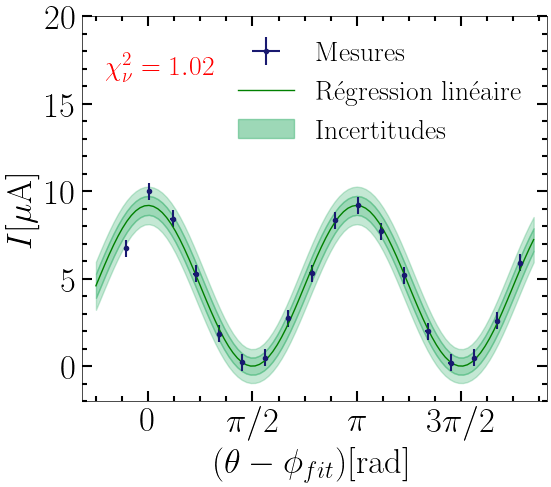

In [4]:
from matplotlib.ticker import MultipleLocator
# Première figure: Intensité versus angle 
fig, axs = plt.subplots(1, 1, figsize = (6, 5))
ax = axs

# Afficher mesures avec erreurs
x = theta - phi_fitted # tableau de valeurs axe des x
ax.errorbar(x = x, 
            y = intensity * 1e3, 
            xerr = sigma_theta, 
            yerr = sigma_intensity * 1e3, 
            fmt = '.', 
            elinewidth=1.5, 
            label = 'Mesures', 
            color = 'midnightblue'
            )

# Afficher prédiction du model 
x_range = np.array([-np.pi / 4, 2 * np.pi])
x_fit =  np.linspace(x_range.min(), x_range.max()-phi_fitted + 0.2, 100)
intensity_fitted = malus_law(x_fit + phi_fitted, *phys_fitted)
ax.plot(x_fit, intensity_fitted * 1e3, "green", label = 'Régression linéaire')

# Afficher incertitudes sur la régression linéaire
std_intensity = np.sqrt(std_malus(theta = x_fit + phi_fitted, phys_fitted = phys_fitted, phys_std = phys_std, std_theta=sigma_theta) **2 + sigma_intensity ** 2)

# Beautiful uncertainty zones 
k1 = 1
ax.fill_between(
    x = x_fit, 
    y1 = (intensity_fitted - k1 * std_intensity) * 1e3, 
    y2 = (intensity_fitted + k1 * std_intensity) * 1e3,
    color = 'mediumseagreen', 
    alpha = 0.5, 
    label = r'Incertitudes'
    )
k2 = 2
ax.fill_between(
    x = x_fit, 
    y1 = (intensity_fitted - k1 * std_intensity -1e-5) * 1e3, 
    y2 = (intensity_fitted - (k2) * std_intensity) * 1e3,
    color = 'mediumseagreen', 
    alpha = 0.3
    )

ax.fill_between(
    x = x_fit, 
    y1 = (intensity_fitted + k1 * std_intensity +1e-5) * 1e3, 
    y2 = (intensity_fitted + (k2) * std_intensity) * 1e3,
    color = 'mediumseagreen', 
    alpha = 0.3
    )
# Rendre la figure plus jolie :) 
ax.set(xlabel = r"$(\theta-\phi_{fit})$[rad]", ylabel = r"$I$[$\mu$A]", xlim = [-1, 6.], ylim = [-2, 20])
x_ticks = np.arange(0, 5, np.pi/2)
x_tick_labels = [r"$0$", r"$\pi/2$", r"$\pi$", r"$3\pi/2$"]
ax.xaxis.set_ticks(x_ticks)
ax.xaxis.set_ticklabels(x_tick_labels)

ax.tick_params(which = 'major', axis = 'both', length = 7, width = 1.5)
ax.tick_params(which = 'minor', axis = 'both', length = 3.5, width = 1.5)
ax.annotate(r"$\chi^2_{\nu} = %.2f$"%chi2, xy = (0.05, 0.85), xycoords = 'axes fraction', color = 'r', fontsize = 20)
handles, labels = plt.gca().get_legend_handles_labels()
order = [2,0,1]
ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order])
plt.savefig(os.path.join(figure_folder, 'figure_malus.pdf'), bbox_inches = 'tight')
# maj_ticks = 

(array([ 1.,  0.,  4., 11.,  2.]),
 array([-3.07211272, -2.12111694, -1.17012116, -0.21912538,  0.73187039,
         1.68286617]),
 <BarContainer object of 5 artists>)

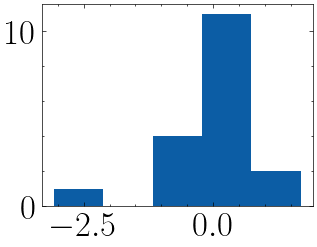

In [5]:
plt.hist(norm_residuals, bins = 5)

### Calcul de la largeur spectrale du pic d'émission du laser 
Commençons par importer les données et puis par estimer l'incertitude sur le 'counts' mesuré par le spectromètre

In [6]:
def import_data(filename):
    wavelength = []
    intensity = []
    with open(filename, "r") as f: 
        lines = f.readlines()
        lines = lines[17:-1]
        for line in lines:
            line = line.strip()
            line = line.split("\t")
            wavelength.append(float(line[0].replace(",", "."))) # counts 
            intensity.append(float(line[1].replace(",", "."))) # nanometers 
    return np.array(wavelength), np.array(intensity)

def get_window(wavelength, intensity, wavelength_center = 1064, extent = 50):
    """
    Prendre une tranches (en termes de longueur d'ondes) de données 
    """
    idx_center = np.argmin(abs(wavelength - wavelength_center))
    D, U = idx_center - extent, idx_center + extent
    return wavelength[D:U], intensity[D:U]


In [7]:
from glob import glob
from tqdm import tqdm 
pattern = "450_std*.txt"
std_files = glob(os.path.join(figure_folder, pattern))

std_file = std_files[0]
wavelength = []
intensity = []

low_center = 808 #nm
high_center = 1064 #nm
multiple_intensity_peaks = np.empty(shape = (len(std_files), 2))

for i, std_file in tqdm(enumerate(std_files)):
    wavelength, intensity = import_data(filename = std_file)

    wavelength_low, intensity_low = get_window(wavelength = wavelength, 
                                            intensity = intensity, 
                                            wavelength_center = low_center, 
                                            extent = 500) 

    wavelength_high, intensity_high = get_window(wavelength = wavelength, 
                                            intensity = intensity, 
                                            wavelength_center = high_center, 
                                            extent = 500) 
    multiple_intensity_peaks[i] = np.array([intensity_low.max(), intensity_high.max()])


10it [00:00, 60.47it/s]


In [62]:
sigma_wavelength = np.diff(wavelength).mean() # nm
sigma_intensity = multiple_intensity_peaks.std(axis = 0, ddof = 1).max() # 

In [63]:
sigma_wavelength

np.float64(0.1636363636363595)

Le bruit de l'instrument semble varier avec l'intensité (ou peut-être la longueur d'onde?)... Puisque nous n'avons pas accès à la fonction de réponse du spectromètre selon la longueur d'onde, faisons pour l'instant l'hypothèse d'un bruit constant.

On peut maintenant importer les données pour le fit de la Gaussienne.

19258.58583333333


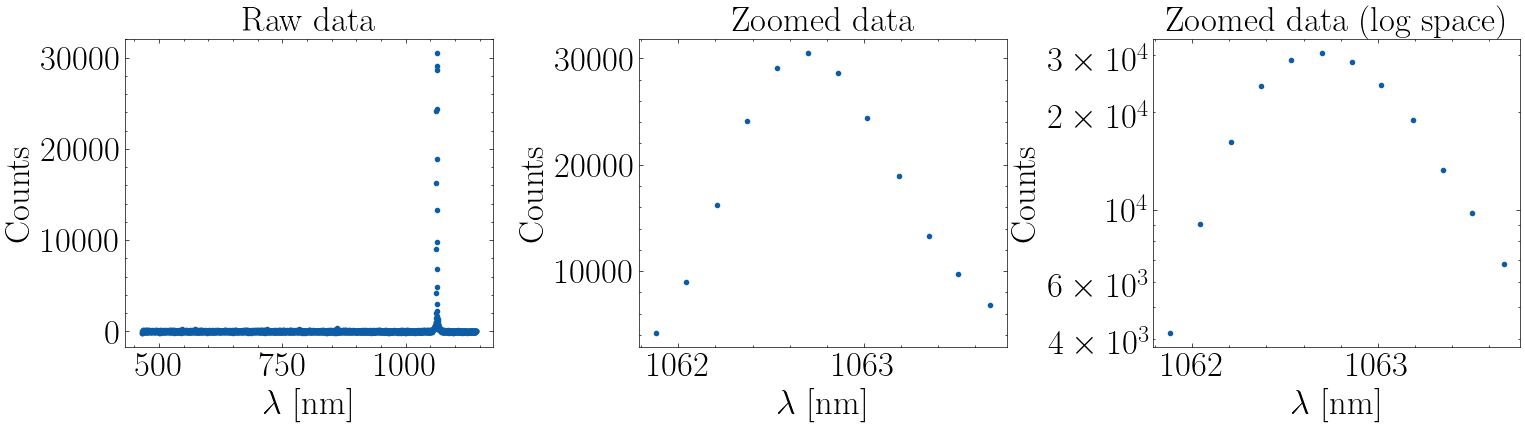

In [64]:
filename = os.path.join(figure_folder, "spectral_width_low_counts.txt")

wavelength_full, intensity_full = import_data(filename = filename)
print(intensity.mean())
high_center = 1062.9
wavelength_window, intensity_window = get_window(wavelength = wavelength_full, 
                                            intensity = intensity_full, 
                                            wavelength_center = high_center, 
                                            extent = 6) 

# Calcul d'ordonnée à l'origine à retirer (bruit ambiant)
wavelength_window_noise, intensity_window_noise = get_window(wavelength = wavelength_full, 
                                            intensity = intensity_full, 
                                            wavelength_center = 700, 
                                            extent = 1000)
offset = intensity_window_noise.mean()
std = intensity_window_noise.std() 

nrows, ncols = 1, 3
fig, axs = plt.subplots(nrows, ncols, figsize = (6 * ncols, 4 * nrows))

ax = axs[0]
ax.plot(wavelength_full, intensity_full-offset, ".")
ax.set_title("Raw data")


ax = axs[1]
ax.plot(wavelength_window, intensity_window-offset, ".")
ax.set_title("Zoomed data")


ax = axs[2]
ax.plot(wavelength_window, intensity_window-offset, ".")
ax.set_title("Zoomed data (log space)")
ax.set_yscale("log")

for ax in axs: 
    ax.set(xlabel = r"$\lambda$ [nm]", ylabel= r"Counts")
plt.subplots_adjust(wspace=0.4)

# Selection d'une portion des données pour la suite
wavelength = wavelength_window
intensity = intensity_window 

In [65]:
wavelength_window

array([1061.88, 1062.04, 1062.21, 1062.37, 1062.53, 1062.7 , 1062.86,
       1063.02, 1063.19, 1063.35, 1063.51, 1063.68])

On veut maintenant faire une régression linéaire sur une Gaussienne. L'astuce ici est de faire la régression dans l'espace logarithmique. L'intensité (en termes de comptes) est ici définie comme 
$$
\begin{align}
I(\lambda) = I_{0} \exp\left(-\frac{(\lambda-\lambda_0)^2}{2w^2}\right)
\end{align}
$$
où $\lambda_{0}$ est la moyenne de la Gaussienne (là où le pic d'émission du laser est censé se situer)

On peut maintenant appliquer le log
$$
\begin{align}
\ln I (\lambda)&= -\frac{(\lambda - \lambda_0)^2}{2w^2} + \ln(I_0)
\\
&= -\frac{1}{2w^2} \left(\lambda^2 - 2 \lambda \lambda_{0} +\lambda_{0}^2\right) + \ln(I_0)
\\
&= \underbrace{-\frac{1}{2w^2}}_{\beta_0} \lambda^2 + \underbrace{\frac{\lambda_0}{w^2}}_{\beta_1} \lambda - \underbrace{\frac{\lambda_{0}^{2}}{2w^2} + \ln(I_0)}_{\beta_2}
\\
&= \beta_2 + \beta_1 \lambda + \beta_0 \lambda^2 
\end{align}
$$

On isole maintenant les variables $\lambda_0, w, I_0$ à partir des paramètres de la régression linéaire
$$
\begin{align}
w^2 &= -\frac{1}{2 \beta_0} \Longrightarrow  \sigma_{w^2} = \frac{1}{2 \beta_0^2} \sigma_{\beta_0}
\\
\lambda_0 &= w^2 \beta_1 =-\frac{\beta_1}{2 \beta_0}\Longrightarrow \sigma_{\lambda_0} = \sqrt{\beta_1^2 \sigma_{w^2}^2 + (w^2)^2 \sigma_{\beta_1}^2} 
\\
\beta_2 &= -\frac{\lambda_0^2}{2w^2} + \ln(I_0) \Longrightarrow \lambda_0^2=\frac{\beta_1^2}{4\beta_0^2} \Longrightarrow \frac{\lambda_0^2}{2w^2}=-\frac{\beta_1^2}{4\beta_0} 
\\
I_0 &= e^{\beta_2+\frac{\lambda_0^2}{2w^2}} = 
\exp\left( 
    \beta_2 + \frac{\lambda_0^2}{2w^2}
\right) 
\Longrightarrow 
\sigma_{I_0} = \exp\left( 
    \beta_2 + \frac{\lambda_0^2}{2w^2}
\right) \sqrt{
    \sigma_{\beta_{2}}^2 
    + 
    \frac{\lambda_{0}^2}{(w^2)^2}\sigma_{\lambda_0}^2
    + 
    \frac{\lambda_0^4}{4(w^2)^4}\sigma_{w^2}^2
    }
\end{align}
$$

Finalement, il faut propager les incertitudes en espace logarithmique: 
$$
\sigma_{\ln(I)} = \Biggr \lvert \frac{\partial \ln(I)}{\partial I} \Biggr \rvert  \sigma_I= \frac{\sigma_{I}}{I} \, .
$$

Ici, on semble un peu embêté aux premiers abords afin d'inclure l'incertitude sur $\ln(I)$; l'incertitude dépend de l'intensité elle-même et n'est pas constante ! La solution (fréquentiste) est de minimiser le "weighted chi squared", ou le poids est défini comme $w(I)=\frac{1}{\sigma^{2}_{\ln(I)}}$. Une version de la régression pondérée (qui a une solution analytique) est implémentée dans l'objet `FrequentistRegression` avec la méthode `wfit`. 

In [66]:
def gaussian_profile(wavelength, I0, wavelength_center, width): 
    I = I0 * np.exp( -(wavelength - wavelength_center) ** 2 / (2 * width) ** 2)
    return I

def params_to_phys(params, std_params): 
    beta0, beta1, beta2 = params
    std_beta0, std_beta1, std_beta2 = std_params
    var = -1 / (2 * beta2)
    mu = - beta1 / (2 * beta2)
    A = np.exp(beta0 + mu ** 2 / (2 * var))

    std_var = std_beta2 / (2 * beta2 ** 2)
    # std_mu = np.sqrt(var ** 2 * std_beta1 ** 2 + std_var ** 2 * beta1 ** 2)
    std_mu = np.sqrt( (std_beta1 / (2 * beta2)) ** 2 + (beta1 * std_beta2 / (2*beta2 ** 2))**2)
    std_A = A * np.sqrt(std_beta0 ** 2 + mu ** 2 / (var) ** 2 * std_mu ** 2 + std_var ** 2 * (mu / var) ** 4)
    return np.array([A, mu, var]), np.array([std_A, std_mu, std_var])


def compute_fwhm(sigma): 
    """
    Compute the FWHM of a Gaussian from its standard deviation
    """
    return 2 * np.sqrt(2 * np.log(2)) * sigma

In [67]:
Regression_width = FrequentistRegression(
    degree = 2,
    sigma_noise = (sigma_intensity)/intensity,
) 

params_fitted, std_fitted = Regression_width.wfit(
    obs = np.log(intensity), 
    x = wavelength, 
    ridge_reg = 0, 
    fit_intercept = True
)

chi2 = Regression_width.compute_chi2(
    obs = np.log(intensity)
)
print( "chi", chi2)

phys_fitted, phys_std = params_to_phys(params_fitted, std_fitted)
pred_intensity_log = Regression_width.forward_model()

print(phys_fitted)
print(phys_std)
print(Regression_width.cov)

chi 1.037102838583775
[3.03868184e+04 1.06274075e+03 2.73844086e-01]
[1.80498974e+10 1.20071422e+02 2.18771313e-02]
[[ 2.71455786e+10 -5.10835591e+07  2.40327326e+04]
 [-5.10835590e+07  9.61309454e+04 -4.52256941e+01]
 [ 2.40327325e+04 -4.52256940e+01  2.12768479e-02]]


WoW ! Les incertitudes sont plutôt grandes ! La raison est que la matrice de Covariance a des éléments hors de la diagonale très grand, par conséquent nous ne pouvons pas utiliser la formule usuelle de propagation des incertitudes. A la place, je propose ici un moyen rapide de calculer la covariance sur les paramètres physiques en utilisant jax et l'autodifférentiation. 

In [68]:
import jax.numpy as jnp
from jax import jacfwd



def params_to_phys(beta):
    beta_0, beta_1, beta_2 = beta
    sigma_squared = -1 / (2 * beta_2)
    mu = -beta_1 / (2 * beta_2)
    print()
    A = jnp.exp( beta_0 +(mu**2) / (2 * sigma_squared))
    return jnp.array([A, mu, sigma_squared])

cov = Regression_width.cov
jacobian = jacfwd(params_to_phys)(params_fitted)
eigvals = jnp.linalg.eigvals(cov)
epsilon = 5e-8  # Small regularization term for the covariance
cov_regularized = cov + epsilon * np.eye(cov.shape[0])
var = np.sqrt(np.diag(np.array(jacobian @ cov_regularized @ jacobian.T)))

print(params_to_phys(params_fitted))
print(var)



[3.0386812e+04 1.0627407e+03 2.7384409e-01]
[7.4330360e+06 1.3383645e-01 2.1877158e-02]


C'est un peu mieux mais on a encore un problème pour l'amplitude de la Gaussienne... En fait, cet effet semble être du au fait que l'on a un petit nombre de points ici (l'effet est reproduit sur des données simulées dans le notebook `frequentist_vs_bayesian_regression.ipynb`). Essayons de voir ce qui se passe avec une autre méthode. 

In [69]:
from scipy.optimize import curve_fit

parameters_fitted, cov = curve_fit(gaussian_profile, wavelength, intensity)
print(parameters_fitted)
print(cov)

[1. 1. 1.]
[[inf inf inf]
 [inf inf inf]
 [inf inf inf]]


C:\Users\noedi\AppData\Local\Temp\ipykernel_22180\3019345568.py:3: OptimizeWarning: Covariance of the parameters could not be estimated
  parameters_fitted, cov = curve_fit(gaussian_profile, wavelength, intensity)


`curve_fit` semble avoir le même problème à la différence qu'il ne parvient pas à obtenir les paramètres de régression optimaux (en même temps nous lui donnons une exponentielle en entrée!). Pour la suite, comme nous sommes malheureusement limités par le temps, j'assume une incertitude nulle sur les paramètres de régression et considère seulement les incertitudes dues aux instruments de mesure. 

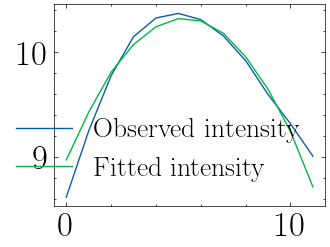

In [70]:
plt.plot(np.log(intensity), label = "Observed intensity")
plt.plot(pred_intensity_log, label = "Fitted intensity")
# plt.fill_between(np.arange(0, len(pred_intensity_log)), y1 = pred_intensity_log - )
plt.legend()

<!-- Parfait, nous avons nos valeurs physiques optimales. Maintenant, propageons les incertitudes sur notre profil Gaussien pour obtenir une incertitude sur les prédictions de notre modèle. 
$$
\begin{align}
\sigma_{I_{m}}^2 = \sigma_{I}^2 + \left(\frac{\partial I}{\partial I_{0}}\right)^2 \sigma_{I_{0}}^2+\left(\frac{\partial I}{\partial \lambda_{0}}\right)^2 \sigma_{\lambda_{0}}^2
+ 
\left(\frac{\partial I}{\partial \lambda}\right)^2 \sigma_{\lambda}^2
+ 
\left(\frac{\partial I}{\partial w}\right)^2 \sigma_{w}^2
\end{align}
$$

... Ça fait beaucoup.
Allons-y: 
$$
\begin{align}
\frac{\partial I}{\partial I_{0}} &= \exp\left(-\frac{(\lambda-\lambda_0)^2}{2w^2}\right)
\\
\frac{\partial I}{\partial \lambda} &= \frac{I_{0}}{w^2}(\lambda - \lambda_0)\exp\left(-\frac{(\lambda-\lambda_0)^2}{2w^2}\right)
\\
\frac{\partial I}{\partial \lambda_{0}} &= \frac{I_{0}}{w^2}(\lambda - \lambda_0)\exp\left(-\frac{(\lambda-\lambda_0)^2}{2w^2}\right)
\\
\frac{\partial I}{\partial w^2} &= \frac{I_{0}}{2w^4}(\lambda - \lambda_0)^2\exp\left(-\frac{(\lambda-\lambda_0)^2}{2w^2}\right)
\end{align}
$$ -->

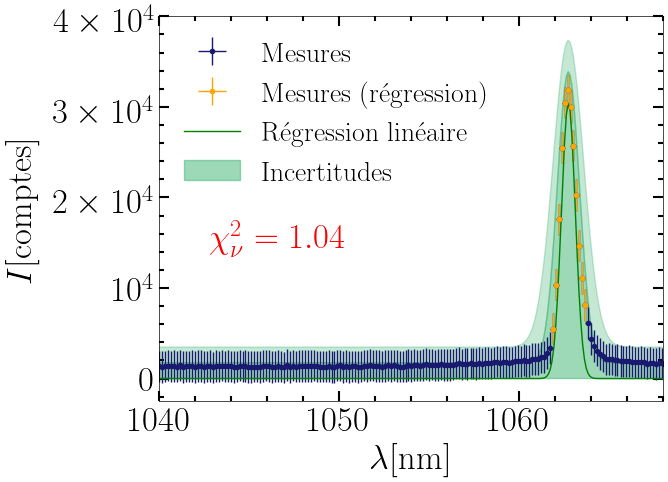

In [89]:
wavelength_fit = np.linspace(wavelength.min()-500, wavelength.max()+500, int(1e4))


fig, axs = plt.subplots(1, 1, figsize = (6.5, 5))
ax = axs
ax.errorbar(x = wavelength_full, y = intensity_full, fmt = ".", xerr=sigma_wavelength, yerr=sigma_intensity, label = "Mesures", color = "midnightblue")
ax.errorbar(x = wavelength, y = intensity, fmt = ".", xerr=sigma_wavelength, yerr=sigma_intensity, label = "Mesures (régression)", color = "orange")
intensity_prediction = gaussian_profile(wavelength_fit, *phys_fitted)
# intensity_min_x =  gaussian_profile(wavelength_fit, phys_fitted[0], wavelength_center = phys_fitted[1]-k*sigma_wavelength, width = phys_fitted[2])
ax.plot(wavelength_fit, intensity_prediction, label = "Régression linéaire", color = "green")


# First uncertainty zone 
k = 1
intensity_max_x =  gaussian_profile(wavelength_fit, phys_fitted[0] + k* sigma_intensity, wavelength_center = phys_fitted[1], width = phys_fitted[2] + k* sigma_wavelength) + k*sigma_intensity
intensity_min_x =  gaussian_profile(wavelength_fit, phys_fitted[0] + k* sigma_intensity, wavelength_center = phys_fitted[1], width = phys_fitted[2] + k* sigma_wavelength) - k*sigma_intensity
# ax.fill_between(wavelength_fit, 
#                  intensity_min_x.min(),  
#                  intensity_max_x, 
#                  color='mediumseagreen', 
#                  label = "Incertitudes",
#                  alpha=0.5)
ax.fill_between(wavelength_fit, 
                 0,  
                 intensity_max_x, 
                 color='mediumseagreen', 
                 label = "Incertitudes",
                 alpha=0.5)

k = 2
intensity_max_x2 =  gaussian_profile(wavelength_fit, phys_fitted[0] + k* sigma_intensity, wavelength_center = phys_fitted[1], width = phys_fitted[2] + k* sigma_wavelength) + k*sigma_intensity
ax.fill_between(wavelength_fit, 
                 intensity_max_x,  
                 intensity_max_x2, 
                 color='mediumseagreen', 
                 alpha=0.3)

# ax.fill_between(wavelength_fit, 
#                  intensity_min_x.min(),  
#                  -k * abs(intensity_min_x.min()), 
#                  color='mediumseagreen', 
#                  alpha=0.3)

# ax.fill_between(wavelength_fit, 
#                  intensity_min_x.min(),  
#                  -k * abs(intensity_min_x.min()), 
#                  color='mediumseagreen', 
#                  alpha=0.3)
                 
xmin = 1040
xmax = 1068
x_ticks = np.arange(xmin, xmax+1, 10, dtype=np.int16)
x_tick_labels = x_ticks
y_ticks = np.arange(0, 45001, 10000)
y_tick_labels = [r"$0$", r"$10^4$", r"$2\times 10^4$", r"$3 \times 10^4$", r"$4 \times 10^4$"]
ax.xaxis.set_ticks(x_ticks)
ax.xaxis.set_ticklabels(x_tick_labels)
ax.yaxis.set_ticks(y_ticks)
ax.yaxis.set_ticklabels(y_tick_labels)
ax.tick_params(which = 'major', axis = 'both', length = 7, width = 1.5)
ax.tick_params(which = 'minor', axis = 'both', length = 3.5, width = 1.5)
ax.annotate(r"$\chi^2_{\nu} = %.2f$"%chi2, xy = (0.1, 0.4), xycoords = 'axes fraction', color = 'r', fontsize = 20)
ax.set(xlabel = r"$\lambda$[nm]", xlim = (xmin, xmax))
ax.set_ylabel(ylabel = r"$I$[comptes]", labelpad=10)
handles, labels = plt.gca().get_legend_handles_labels()
order = [2, 3,0,1]
ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc = "upper left")
# ax.legend()
plt.savefig(os.path.join(figure_folder, 'figure_width_temp.pdf'), bbox_inches = 'tight')


In [85]:
print(f"Pic d'intensité {phys_fitted[0]:.3g} +/- {sigma_intensity:.3g} comptes")
print(f"Pic d'émission à {phys_fitted[1]:.0f} +/- {sigma_wavelength:.3g} nm")
print(f"Largeur de la Gaussienne à {np.ceil(phys_fitted[2]):.0f} +/- {sigma_wavelength:.3g} nm")

Pic d'intensité 3.04e+04 +/- 1.74e+03 comptes
Pic d'émission à 1063 +/- 0.164 nm
Largeur de la Gaussienne à 1 +/- 0.164 nm


### Comparaison pics à pics de l'intensité à 808 nm vs 1064 nm 
Cette partie consiste juste à voir comment varie le rapport pic à pic entre l'émission de base du laser et celle qui passe au travers du cristal (nom compliqué). Le rapport que je considère ici (on peut considérer l'inverse de manière équivalente) est
$$
r(I_{p})=\frac{I_{max, 1064}}{I_{max, 808}}
$$

On propage maintenant les incertitudes pour obtenir l'incertitude sur $r$. Nous assumons l'indépendance des termes ici, puisque nous ne sommes pas en capacité d'évaluer la corrélation entre les deux pics. 
$$
\sigma_{r} = \sqrt{\frac{1}{I_{max,808}^2}\sigma_{I_{max, 1064}}^2 + \frac{I_{max, 1064}^2}{I_{max, 808}^4}\sigma_{I_{max, 808}}^2}
$$
On assume également que $\sigma_{I_{max, 1064}}=\sigma_{I_{max, 808}}$

In [17]:
sigma_intensity_peaks = multiple_intensity_peaks.std(axis = 0, ddof = 1)
sigma_808, sigma_1064 = sigma_intensity_peaks

In [18]:
# Importing list of paths of data with two peaks 
pattern = "*_double_5ms.txt"
paths = glob(os.path.join(figure_folder, pattern))

# Choosing the two peaks centers
low_center = 808 # nm
high_center = 1064 # nm

# Pour stocker les données
Ip = [] # Courant de pompe
rapport = [] # I_1064 / I_808
std = []

num = 5 # Number of data points to estimate the maximum

# Itération sur tous les fichiers
for path in paths: 
    Ip.append(float(os.path.basename(path).split("_")[0]))
    wavelength, intensity = import_data(filename = path)    
    wavelength_low, intensity_low = get_window(wavelength = wavelength, 
                                                intensity = intensity, 
                                                wavelength_center = low_center, 
                                                extent = 100) 
    # I_808_max = np.max(intensity_low)
    I_808_max = np.mean(np.partition(intensity_low, -num)[-num:]) # np.partition (partial sort) is more efficient than np.sort (full sort)

    wavelength_high, intensity_high = get_window(wavelength = wavelength, 
                                                intensity = intensity, 
                                                wavelength_center = high_center, 
                                                extent = 100) 
    # I_1064_max = np.max(intensity_high)
    I_1064_max = np.mean(np.partition(intensity_high, -num)[-num:])
    rapport.append(I_1064_max / I_808_max)
    std.append(np.sqrt(sigma_1064** 2 / (I_808_max ** 2) + (I_1064_max ** 2)* sigma_808 ** 2 / (I_808_max) ** 4))

Ip = np.array(Ip)
rapport = np.array(rapport)
sigma_Ip = 0.1 # mA
sigma_r = np.array(std)

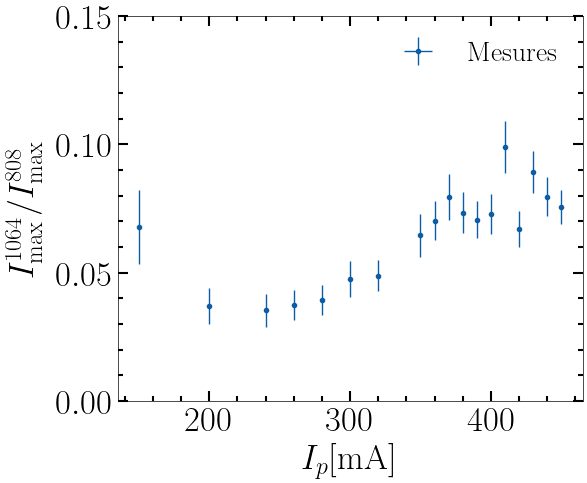

In [19]:
fig, axs = plt.subplots(1, 1, figsize = (6, 5))

ax = axs
ax.errorbar(Ip, rapport, fmt = ".", xerr = sigma_Ip, yerr = sigma_r, label = 'Mesures')

ax.set(xlabel = r"$I_{p}$[mA]", ylim = (0, 0.15))
ax.set_ylabel(r"$I_{\mathrm{max}}^{1064}/I_{\mathrm{max}}^{808}$", labelpad = 10)
ax.tick_params(which = 'major', axis = 'both', length = 7, width = 1.5)
ax.tick_params(which = 'minor', axis = 'both', length = 3.5, width = 1.5)
ax.legend()
plt.savefig(os.path.join(figure_folder, 'figure_rapport.pdf'), bbox_inches = 'tight')

In [20]:
intensity

array([1058.8 , 1058.8 , 1058.8 , ..., 1132.53, 1132.53, 1132.53])

## Semaine 2: 
***[Musique de la semaine 2](https://www.youtube.com/watch?v=eFTLKWw542g)***

Cette semaine, nous faisons la partie sur la Génération de Seconde Harmonique (GHS). 3 expériences en tout que nous faisons: 
- Mesures de l'intensité relative du pic d'émission correspondant au GHS
- Mesures de l'intensité de l'émission correspondant au GHS selon l'angle d'une lame demi-onde  
- Bonus: Mesure de l'intensité relative du pic d'émission en fonction de l'angle que fait le cristal KTP par rapport à la verticale. 

Commençons par le commencement, voici la musique de la semaine: 

### Intensité pic GHS vs intensité laser à 1064 nm 

Nous voulons démontrer une relation de la forme 
$$
I_{GHS}\propto I_{1064}^2.
$$

Nous voulons plus spécifiquement montrer l'exposant 2 ici. Écrivons la relation plus générale dans l'espace logarithmique avec un exposant $p$: 
$$
\ln I_{GHS} = p\ln I_{1064} + C
$$


In [21]:
name_file = "Double_freq.txt" 
fname = os.path.join(figure_folder, name_file)

In [191]:
data = np.array([[0.00107, 0.00001],
[0.00117,			0.00002],
[0.00216,			0.00003],
[0.00311,			0.00004],
[0.00434,			0.00005],
[0.00590,			0.00006],
[0.00818,			0.00009],
[0.01742,			0.00009],
[0.02203,			0.0001],
[0.02543,			0.00011],
[0.0296,			0.00012],
[0.03246,			0.00013],
[0.03464,			0.00013]])

data_std = np.array([
    0.02053,
    0.01933,
    0.01719,
    0.01999,
    0.01763,
    0.01746,
    0.01894,
    0.02342,
    0.01623,
    0.01802
]) #* u.microampere.to(u.milliampere)

sigma = data_std.std(ddof = 1)
I_laser = data[:, 1] * u.milliampere.to(u.microampere) # mA
I_ghs = data[:, 0] # mA (originalement en micro-ampere)

[]

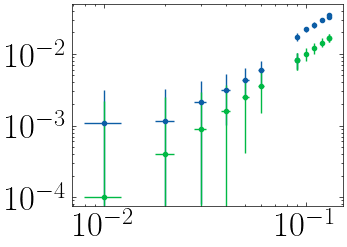

In [192]:
plt.errorbar(I_laser, I_ghs, fmt=".", xerr = sigma, yerr = sigma)
plt.errorbar(I_laser, I_laser** (2), fmt=".", xerr = sigma, yerr = sigma)
plt.loglog()

Comme l'incertitude des données varie avec l'intensité ici, on utilise la méthode `wfit`

In [193]:
obs = np.log(I_ghs)
x = np.log(I_laser)
sigma_noise = sigma / I_ghs
Regression_ghs = FrequentistRegression(
    degree = 1,
    sigma_noise = sigma_noise 
) 

params_fitted, std_fitted = Regression_ghs.wfit(
    obs = obs, 
    x = x, 
    ridge_reg = 0, 
    fit_intercept = True
)
chi2 = Regression_ghs.compute_chi2(obs = obs)
y_pred = Regression_ghs.forward_model()
print("Chi carré:", chi2)
print("Fitted parameters:", params_fitted)
print("Uncertainty on fitted parameters:", std_fitted)
print("Covariance", Regression_ghs.cov) # A bit of correlation here... Let's ignore it ! 

Chi carré: 0.9777604284358626
Fitted parameters: [0.64886956 1.97350087]
Uncertainty on fitted parameters: [0.39568384 0.18361644]
Covariance [[0.1565657  0.07244487]
 [0.07244487 0.033715  ]]


On a une corrélation de l'ordre de grandeur des éléments diagonaux. Le $\chi^2$ est plutôt élevé ce qui indique que nous sommes en train de sous-estimer nos incertitudes selon les observations que nous avons.  

Propageons les incertitudes de régression dans la formule linéaire en assumant l'indépendance des variables aléatoires. On a 
$$
y = p x + b
$$

$$
\sigma_{y} = \sqrt{x^2 \sigma_{p}^2 + p^2\sigma_x^2 + \sigma_b^2}
$$
Ici, $\sigma_{x}=\sigma_{\log{I_{1064}}}=\frac{\sigma_{I_{1064}}}{I_{1064}}$

In [214]:
def model(log_I_ghs, params):
    return params[0] + log_I_ghs * params[1]

def std_model(log_I_laser, std_laser, params, std_params): 
    b, p = params
    sigma_b, sigma_p = std_params
    return np.sqrt(log_I_laser ** 2 * sigma_p ** 2 + p ** 2 * std_laser **2 + sigma_b ** 2)

In [161]:
params_fitted

array([0.64886956, 1.97350087])

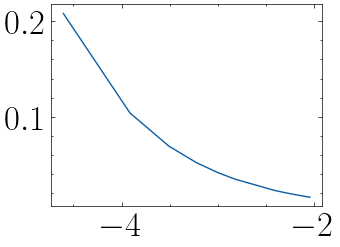

In [223]:
plt.plot(x, sigma/I_laser)

In [225]:
std_quad = np.sqrt(std_fitted**2 + ((sigma / x_fit)**2))

ValueError: operands could not be broadcast together with shapes (2,) (1000,) 

In [227]:
std_reg

array([0.99972062, 0.99921428, 0.99870797, 0.99820172, 0.99769552,
       0.99718936, 0.99668325, 0.99617719, 0.99567118, 0.99516521,
       0.9946593 , 0.99415343, 0.99364761, 0.99314184, 0.99263611,
       0.99213044, 0.99162482, 0.99111924, 0.99061371, 0.99010823,
       0.9896028 , 0.98909742, 0.98859209, 0.98808681, 0.98758158,
       0.9870764 , 0.98657126, 0.98606618, 0.98556115, 0.98505616,
       0.98455123, 0.98404634, 0.98354151, 0.98303672, 0.98253199,
       0.9820273 , 0.98152267, 0.98101808, 0.98051355, 0.98000907,
       0.97950464, 0.97900025, 0.97849592, 0.97799164, 0.97748741,
       0.97698324, 0.97647911, 0.97597503, 0.97547101, 0.97496703,
       0.97446311, 0.97395924, 0.97345542, 0.97295165, 0.97244794,
       0.97194427, 0.97144066, 0.9709371 , 0.97043359, 0.96993014,
       0.96942673, 0.96892338, 0.96842008, 0.96791683, 0.96741364,
       0.9669105 , 0.96640741, 0.96590437, 0.96540139, 0.96489845,
       0.96439558, 0.96389275, 0.96338998, 0.96288726, 0.96238

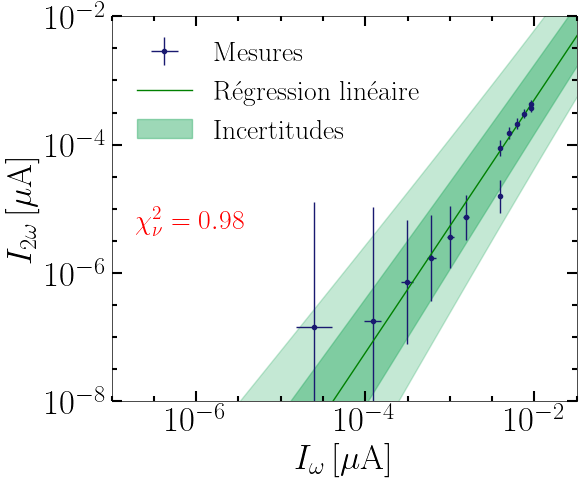

In [262]:
fig, axs = plt.subplots(1, 1, figsize = (6, 5))
x_fit = np.linspace(-8, 5, 1000)
y_pred_fit = model(x_fit, params_fitted)
axs.errorbar(x, obs, fmt = ".", xerr = sigma/I_laser, yerr = sigma/I_ghs, label = "Mesures", color = "midnightblue")
axs.plot(x_fit, y_pred_fit, label = "Régression linéaire", color = "green")

# Uncertainty zones:
k1 = 1
std_reg = std_model(x_fit, sigma/x_fit, params_fitted, std_fitted)
std_inst = sigma / x_fit
std = np.sqrt(std_reg ** 2 + std_inst ** 2)
y_pred_min = y_pred_fit - k1 * std
y_pred_max =  y_pred_fit + k1 * std
axs.fill_between(
    x = x_fit, 
    y1 = y_pred_min, 
    y2 = y_pred_max, 
    color = "mediumseagreen",
    alpha = 0.5,
    label = "Incertitudes"
)

k2 = 2
std_reg = std_model(x_fit, sigma/x_fit, params_fitted, std_fitted)
std_inst = sigma / x_fit
std = np.sqrt(std_reg ** 2 + std_inst ** 2)
y_pred_min_2 = y_pred_fit - k2 * std
y_pred_max_2 =  y_pred_fit + k2 * std
axs.fill_between(
    x = x_fit, 
    y1 = y_pred_min_2, 
    y2 = y_pred_max_2, 
    color = "mediumseagreen",
    alpha = 0.3
)

# Annotating the chi squared
axs.annotate(r"$\chi^2_{\nu}=%.2f$"%chi2, xy = (0.05, 0.45), xycoords = "axes fraction", color = "red")

# Changing the ticks 
xmin = -7
xmax = -1.5
ymin = -8
ymax = -2
x_ticks = np.arange(xmin+1, xmax+2, 2, dtype=np.int16)
x_tick_labels = x_ticks
y_ticks = np.arange(ymin, ymax+1, 2, dtype=np.int16)
x_tick_labels =  [r"$10^{%d}$"%i for i in x_ticks]
y_tick_labels =  [r"$10^{%d}$"%i for i in y_ticks]
axs.xaxis.set_ticks(x_ticks)
axs.xaxis.set_ticklabels(x_tick_labels)
axs.yaxis.set_ticks(y_ticks)
axs.yaxis.set_ticklabels(y_tick_labels)
axs.tick_params(which = 'major', axis = 'both', length = 7, width = 1.5)
axs.tick_params(which = 'minor', axis = 'both', length = 3.5, width = 1.5)
axs.set(ylabel = r"$I_{\mathrm{GHS}}\, [\mu\mathrm{A}]$", xlabel = r"$I_{1064}\, [\mu\mathrm{A}]$", xlim = [xmin, xmax], ylim = [ymin, ymax])
axs.set(ylabel = r"$I_{2\omega}\, [\mu\mathrm{A}]$", xlabel = r"$I_{\omega}\, [\mu\mathrm{A}]$", xlim = [xmin, xmax], ylim = [ymin, ymax])

handles, labels = plt.gca().get_legend_handles_labels()
order = [2,0,1]
axs.legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc = "upper left")
plt.savefig(os.path.join(figure_folder, "figure_ghs.pdf"), bbox_inches = "tight")

In [257]:
print(f"I_GHS est proportionnelle à I_1064^({params_fitted[1]:.2f} +/- {std_fitted[1]:.2f})")

I_GHS est proportionnelle à I_1064^(1.97 +/- 0.18)


### Mesures intensité en fonction de l'angle de la lame demi-onde.
Une relation entre $I_{2\omega}$ et $I_{\omega}$ peut être dérivée en utilisant le formalisme matriciel de Jones. Choisissons la direction de polarisation du champ électrique incident à $\omega$ comme étant 
$$
\begin{align}
\mathbf{E}_{sortant}&= SP\mathbf{E}_{entrant}
\\
&=
\begin{pmatrix}
1 & 0\\
0 & e^{-i\delta}
\end{pmatrix}
\begin{pmatrix}
\cos(\phi) & \sin(\phi)\\
-\sin(\phi) & \cos(\phi)
\end{pmatrix}
\begin{pmatrix}
E_0 \\ 0
\end{pmatrix}
\\
&= \begin{pmatrix}
E_0\cos(\phi) \\
E_0\sin(\phi)e^{-i\delta} 
\end{pmatrix}\, .
\end{align}
$$
Finalement, pour une raison qui m'échappe encore un peu (puisqu'on ne choisit que des termes croisés et non les termes $E_x^2 + E_y^2$), l'intensité de l'OEM de GHS est déterminée par la relation de proportionnalité
$$
\begin{align}
I_{2\omega} &\propto |E_x E_y|^2
\\
&= E_0^4 \left(\sin(\phi)\cos(\phi)\right)^2
\\
&= \frac{I_{\omega}^2}{4}\sin^2(2\phi)
\end{align}
$$
Pour simplifier la relation, je renomme $2\phi \rightarrow \theta$. On a vérifié précédemment la relation de proportionnalité avec $I^2_{\omega}$. Une dérivation plus formelle faisant appel directement à l'équation d'ondes peut être utilisée pour arriver à une solution similaire à ce qu'on a ci-dessus. La solution formelle a un terme en $\text{sinc}$. Plutôt intéressant, c'est exactement ce genre de fonctions qui apparaît dans le phénomènes de diffraction ! On peut faire un lien direct ici avec le "phase matching". Il est possible d'avoir une différence de phase telle entre l'onde incidente du laser à $\omega$ et l'onde qui pourrait être émise $2\omega$ qu'on a des interférences destructives.

Importons maintenant les données et faisons une Figure. On aura sûrement à introduire un déphasage dans ce qu'on a ci-dessus

In [280]:
theta = np.array([40, 80, 120, 160, 200, 240, 280, 320, 360, 12, 10, 8, 4, -4, -8, -12, -16,])*u.degree.to(u.radian)
sigma_theta = 1 * u.degree.to(u.radian) # demi-mesure de l'angle plus petit mesurable 
I_ghs = np.array([
    0.01105,		
    0.00899,		
    0.00421,		
    0.00242,		
    0.00227,		
    0.0051,		
    0.00834,		
    0.01145	,	
    0.01360,		
    0.00794	,	
    0.00951	,	
    0.01026,		
    0.01258,		
    0.01187,		
    0.01	,	
    0.00721,	 	
    0.00469])	# micro-ampoeres	

x = np.sin(theta) ** 2
sigma_x = 2 * np.cos(theta) * np.sin(theta) * sigma_theta
y = I_ghs 
sigma_y = sigma # micro-amperes

In [281]:
Regression_phase = FrequentistRegression(
    degree = 1,
    sigma_noise = sigma_y 
)

params_fitted, std_fitted = Regression_phase.fit(
    obs = y, 
    x = x, 
    fit_intercept = False,
    ridge_reg = 0
)
y_pred = Regression_phase.forward_model()
chi2 = Regression_phase.compute_chi2(obs=y)

print(y)
print(y_pred)
print(chi2)

[0.01105 0.00899 0.00421 0.00242 0.00227 0.0051  0.00834 0.01145 0.0136
 0.00794 0.00951 0.01026 0.01258 0.01187 0.01    0.00721 0.00469]
[1.08980888e-02 1.31447034e-03 8.42769259e-03 4.64282609e-03
 4.64282609e-03 8.42769259e-03 1.31447034e-03 1.08980888e-02
 2.69642974e-33 1.85897703e-03 1.31447034e-03 8.53735956e-04
 2.17649679e-04 2.17649679e-04 8.53735956e-04 1.85897703e-03
 3.15549022e-03]
13.407718720123501


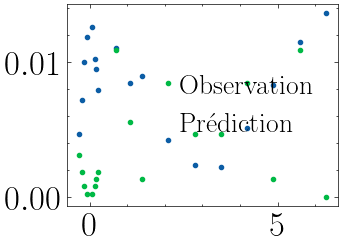

In [282]:
plt.plot(theta, y,  ".", label = "Observation")
plt.plot(theta, y_pred, ".", label = "Prédiction")
plt.legend()

Ajoutons un déphasage pour résoudre le problème. On fait appel aux relations trigonométriques pour développer une forme linéaire pour la relation de proportionnalité précédente
$$
\sin^2(\theta)
$$

In [267]:
sigma_x

array([ 1.71881378e-02,  5.96937761e-03, -1.51149947e-02, -1.12187602e-02,
        1.12187602e-02,  1.51149947e-02, -5.96937761e-03, -1.71881378e-02,
       -8.54964753e-18,  7.09889361e-03,  5.96937761e-03,  4.81077940e-03,
        2.42902884e-03, -2.42902884e-03, -4.81077940e-03, -7.09889361e-03,
       -9.24883593e-03])

In [268]:
sigma_y

np.float64(0.0020808395741462944)

In [30]:
I_laser

array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.09, 0.09, 0.1 , 0.11, 0.12,
       0.13, 0.13])

In [31]:
np.loadtxt(fname)

FileNotFoundError: C://Users//noedi//Desktop//lab_optique//data//optique_non_lineaire\Double_freq.txt not found.